# Performance Analysis of SupplyNetPy  

**Goal:** Assess the computational time complexity of the library as the size of the supply chain increases (i.e., with a growing number of nodes).  

To do this, we define a function that creates a randomly configured supply chain network with a given number of nodes \(N\) and stochastic demand. We then estimate the time required to run a single simulation with \(N\) nodes. For each \(N\), we run \(K\) simulations, record the execution time for each run, and compute the expected runtime.  

Next, we increase the number of nodes \(N\) in the supply chain, generate another randomly configured supply chain network, and repeat the process to determine the relationship between execution time and supply chain size.  


In [2]:
# this script creates supply chain networks with increasing number of nodes 
# and measures the time taken to run a single simulation

import simpy
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import SupplyNetPy.Components as scm
from matplotlib.pyplot import figure

In [7]:
import random

class BaseDist:
    """Base class with helper for generating non-negative samples."""
    @staticmethod
    def non_negative(sample_fn):
        k = -1
        while k < 0:
            k = sample_fn()
        return k

class DemandDist(BaseDist):
    def __init__(self, mean=10, var=2):
        self.mean = mean
        self.var = var

    def gauss(self):
        return self.non_negative(lambda: int(random.gauss(self.mean, self.var)))

    def uniform(self):
        return self.non_negative(lambda: int(random.uniform(self.mean - self.var, self.mean + self.var)))

    def exponential(self):
        return self.non_negative(lambda: int(random.expovariate(1 / self.mean)))

    def constant(self):
        return self.mean

class InterArrivalTimeDist:
    def __init__(self, lam=1.0):
        self.lam = lam

    def poisson(self):
        return random.expovariate(self.lam)

class LeadTimeDist(BaseDist):
    def __init__(self, mean=2, var=1):
        self.mean = mean
        self.var = var

    def gauss(self):
        return self.non_negative(lambda: random.gauss(self.mean, self.var))

    def uniform(self):
        return self.non_negative(lambda: random.uniform(self.mean - self.var, self.mean + self.var))

    def exponential(self):
        return self.non_negative(lambda: random.expovariate(1 / self.mean))

In [8]:
replenishment_policies = [scm.SSReplenishment, scm.RQReplenishment, scm.PeriodicReplenishment]
selection_policies = [scm.SelectAvailable, scm.SelectCheapest, scm.SelectFirst, scm.SelectFastest]
selection_mode = ["fixed","dynamic"]

def generate_supply_chain(n: int, simtime: int, logging: bool = False) -> float:
    """
    Generate a supply chain network with n nodes and measure execution time.

    Node Ratios (Generalized for Balanced Networks):
    - Suppliers to Manufacturers: 3–10 suppliers per manufacturer
    - Manufacturers to Warehouses/Distributors: 1–3 per manufacturer
    - Warehouses/Distributors to Retailers: 1–10 per warehouse/distributor
    """
    env = simpy.Environment()
    supplynet = {"env": env, "nodes": {}, "links": {}, "demands": {}}

    if n < 4:
        print("Cannot create a network with fewer than 4 nodes!")
        return

    # Determine node counts
    num_suppliers = max(1, n // 5)
    num_manufacturers = max(1, n // 10)
    num_distributors = max(1, n // 7)
    num_retailers = n - num_suppliers - num_manufacturers - num_distributors

    #print(f"num_suppliers={num_suppliers}, num_manufacturers={num_manufacturers}, num_distributors={num_distributors}, num_retailers={num_retailers}")

    # Create product and raw material
    rawmat = scm.RawMaterial(ID="rm1", name="raw_material", extraction_time=1,
                             extraction_quantity=100, mining_cost=0.1, cost=1)
    product = scm.Product(ID="p1", name="product", manufacturing_cost=1, manufacturing_time=1,
                          raw_materials=[(rawmat, 1)], sell_price=10, batch_size=100)

    # Helper function for generating random attributes
    def rand_attrs(init_range, hold_range, s_range, buy_range=None, sell_range=None):
        attrs = {
            "initial_level": random.randint(*init_range),
            "inventory_holding_cost": random.uniform(*hold_range),
            "s": random.randint(*s_range)
        }
        if buy_range: attrs["buy"] = random.randint(*buy_range)
        if sell_range: attrs["sell"] = random.randint(*sell_range)
        return attrs

    # Create suppliers
    for i in range(1, num_suppliers + 1):
        ID = f"S{i}"
        supplynet["nodes"][ID] = scm.Supplier(env, ID=ID, name=f"Supplier {i}",
                                              node_type="infinite_supplier", raw_material=rawmat)

    max_dem = int(DemandDist().mean*(DemandDist().mean+DemandDist().var))
    min_dem = int(DemandDist().mean*(DemandDist().mean-DemandDist().var))

    dmax_dem = (num_retailers//num_distributors)*max_dem
    dmin_dem = (num_retailers//num_distributors)*min_dem
    
    mmax_dem = (num_distributors//num_manufacturers)*dmax_dem
    mmin_dem = (num_distributors//num_manufacturers)*dmin_dem

    #print(f"max_dem={max_dem}, min_dem={min_dem}, dmax_dem={dmax_dem}, dmin_dem={dmin_dem}, mmax_dem={mmax_dem}, mmin_dem={mmin_dem}")

    # Create manufacturers
    for i in range(1, num_manufacturers + 1):
        ID = f"M{i}"
        attrs = rand_attrs((mmin_dem, mmax_dem), (0.2, 0.5), (mmin_dem, mmax_dem), sell_range=(product.sell_price, product.sell_price+1))
        supplynet["nodes"][ID] = scm.Manufacturer(env, ID=ID, name=f"Manufacturer {i}",
                                                   capacity=mmax_dem,
                                                   initial_level=attrs["initial_level"],
                                                   inventory_holding_cost=attrs["inventory_holding_cost"],
                                                   replenishment_policy=scm.SSReplenishment,
                                                   policy_param={'s': attrs["s"], 'S': mmax_dem, 'R':attrs["s"], 'Q': mmin_dem, 'T': 1},
                                                   product_sell_price=attrs["sell"], product=product)

        # Create links from suppliers to this manufacturer
        for j in range(1, num_suppliers + 1):
            link_id = f"Ls{j}m{i}"
            supplynet["links"][link_id] = scm.Link(env, ID=link_id,
                                                   source=supplynet["nodes"][f"S{j}"],
                                                   sink=supplynet["nodes"][ID],
                                                   cost=random.randint(1, 3),
                                                   lead_time=LeadTimeDist(mean=2, var=0.1).gauss)
    
    # Create distributors
    for i in range(1, num_distributors + 1):
        ID = f"D{i}"
        attrs = rand_attrs((dmin_dem, dmax_dem), (0.8, 1), (dmin_dem, dmax_dem), buy_range=(product.sell_price-1, product.sell_price), sell_range=(product.sell_price+1, product.sell_price+2))
        supplynet["nodes"][ID] = scm.InventoryNode(env, ID=ID, name=f"Distributor {i}", node_type="distributor",
                                                   capacity=dmax_dem,
                                                   initial_level=attrs["initial_level"],
                                                   inventory_holding_cost=attrs["inventory_holding_cost"],
                                                   replenishment_policy=scm.SSReplenishment,
                                                   policy_param={'s': attrs["s"], 'S': dmax_dem, 'R':attrs["s"], 'Q': dmin_dem, 'T': 1},
                                                   product_buy_price=attrs["buy"], product_sell_price=attrs["sell"],
                                                   supplier_selection_policy=scm.SelectAvailable,
                                                   supplier_selection_mode="dynamic")
        # Links from manufacturers to distributor
        for j in range(1, num_manufacturers + 1):
            link_id = f"Lm{j}d{i}"
            supplynet["links"][link_id] = scm.Link(env, ID=link_id,
                                                   source=supplynet["nodes"][f"M{j}"],
                                                   sink=supplynet["nodes"][ID],
                                                   cost=random.randint(3, 6),
                                                   lead_time=LeadTimeDist(mean=4, var=0.5).gauss)

    # Create retailers and demand
    for i in range(1, num_retailers + 1):
        ID = f"R{i}"
        attrs = rand_attrs((min_dem, max_dem), (1, 1.5), (min_dem, max_dem), buy_range=(product.sell_price, product.sell_price+2), sell_range=(product.sell_price+2, product.sell_price+3))
        supplynet["nodes"][ID] = scm.InventoryNode(env, ID=ID, name=f"Retailer {i}", node_type="retailer",
                                                   capacity=max_dem,
                                                   initial_level=attrs["initial_level"],
                                                   inventory_holding_cost=attrs["inventory_holding_cost"],
                                                   replenishment_policy=random.choice(replenishment_policies),
                                                   policy_param={'s': attrs["s"], 'S': max_dem, 'R':attrs["s"], 'Q': min_dem, 'T': 1},
                                                   product_buy_price=attrs["buy"], product_sell_price=attrs["sell"],
                                                   supplier_selection_policy=scm.SelectAvailable,
                                                   supplier_selection_mode="dynamic")
        # Demand
        demand_id = f"demand_{ID}"
        supplynet["demands"][demand_id] = scm.Demand(env, ID=demand_id, name=f"Demand {i}",
                                                     order_arrival_model=DemandDist().exponential, # around 10 orders per day
                                                     order_quantity_model=DemandDist().uniform, # around 10 units per order
                                                     demand_node=supplynet["nodes"][ID])
        # Links from distributors to retailer
        for j in range(1, num_distributors + 1):
            link_id = f"Ld{j}r{i}"
            supplynet["links"][link_id] = scm.Link(env, ID=link_id,
                                                   source=supplynet["nodes"][f"D{j}"],
                                                   sink=supplynet["nodes"][ID],
                                                   cost=random.randint(1, 3),
                                                   lead_time=LeadTimeDist().gauss)

    # Run simulation
    start_time = time.time()
    scm.simulate_sc_net(supplychainnet=supplynet, sim_time=simtime, logging=logging)
    return time.time() - start_time

In [12]:
#Following code is to measure the time taken to run a single simulation
num_of_nodes_low = 50
inc_step = 50
num_of_nodes_high = 1000
sim_time = 365 # 1 year of simulation time
num_of_sim_runs = 60

print(f"N \t#runs \texe t(mean) \tstd \t\tstd err")
exe_time = {} # list to store execution time for each number of nodes
for N in range(num_of_nodes_low,num_of_nodes_high,inc_step): # run for N number of nodes
    exe_time[f"{N}"] = []
    for i in range(0, num_of_sim_runs): # run for num_of_sim_runs times to find average execution time
        exe_time[f"{N}"].append(generate_supply_chain(n=N,simtime=sim_time))
    print(f"{N} \t{num_of_sim_runs} \t{sum(exe_time[f'{N}'])/num_of_sim_runs:.6f} \t{np.std(exe_time[f'{N}']):.6f} \t{np.std(exe_time[f'{N}'])/np.sqrt(num_of_sim_runs):.6f}")

N 	#runs 	exe t(mean) 	std 		std err
50 	60 	0.333783 	0.054923 	0.007091
100 	60 	0.630943 	0.063172 	0.008155
150 	60 	0.974712 	0.059154 	0.007637
200 	60 	1.430325 	0.090133 	0.011636
250 	60 	3.087228 	0.503236 	0.064967
300 	60 	3.880074 	0.465438 	0.060088
350 	60 	4.771796 	0.544977 	0.070356
400 	60 	6.028801 	0.575689 	0.074321
450 	60 	6.316602 	0.493994 	0.063774
500 	60 	7.741337 	0.775595 	0.100129
550 	60 	8.518380 	0.898612 	0.116010
600 	60 	10.212605 	0.923126 	0.119175
650 	60 	11.598747 	1.075083 	0.138793
700 	60 	12.664524 	0.961598 	0.124142
750 	60 	11.487795 	2.774010 	0.358123
800 	60 	13.063167 	3.559782 	0.459566
850 	60 	13.116038 	6.361114 	0.821216
900 	60 	12.781533 	3.179859 	0.410518
950 	60 	19.276452 	1.694374 	0.218743


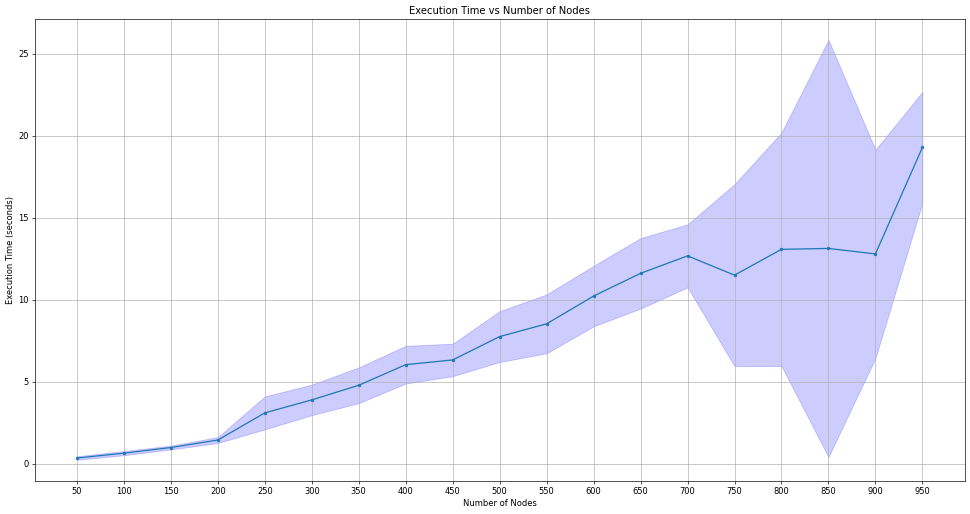

In [ ]:
exe_time = {'50': [0.28284645080566406, 0.3652465343475342, 0.3192768096923828, 0.35184502601623535, 0.28551578521728516, 0.38585329055786133, 0.3336763381958008, 0.3174622058868408, 0.3172140121459961, 0.2794482707977295, 0.29973721504211426, 0.31649136543273926, 0.3996562957763672, 0.3271036148071289, 0.3175058364868164, 0.4618678092956543, 0.39945030212402344, 0.3324439525604248, 0.38637685775756836, 0.3185286521911621, 0.44818639755249023, 0.29546308517456055, 0.3520510196685791, 0.363903284072876, 0.317669153213501, 0.4416391849517822, 0.31714510917663574, 0.5114974975585938, 0.31555891036987305, 0.301055908203125, 0.3495190143585205, 0.314532995223999, 0.3663802146911621, 0.34404802322387695, 0.4333760738372803, 0.34630894660949707, 0.28679919242858887, 0.3000061511993408, 0.2644186019897461, 0.3167695999145508, 0.2835657596588135, 0.3992941379547119, 0.3332641124725342, 0.25595760345458984, 0.28062915802001953, 0.27704763412475586, 0.30043792724609375, 0.4030592441558838, 0.28496885299682617, 0.28514885902404785, 0.32169628143310547, 0.3203456401824951, 0.31464624404907227, 0.2671525478363037, 0.44173169136047363, 0.26662254333496094, 0.3333299160003662, 0.2746405601501465, 0.31662607192993164, 0.2829408645629883],
            '100': [0.6837270259857178, 0.563854455947876, 0.6558096408843994, 0.5836021900177002, 0.6497631072998047, 0.5675826072692871, 0.5811483860015869, 0.7463538646697998, 0.6304712295532227, 0.7206838130950928, 0.5632383823394775, 0.5750548839569092, 0.6834194660186768, 0.6190555095672607, 0.6667289733886719, 0.5626683235168457, 0.5806746482849121, 0.6027145385742188, 0.6457939147949219, 0.6521203517913818, 0.6000568866729736, 0.5799779891967773, 0.6012616157531738, 0.5841190814971924, 0.6925332546234131, 0.5490574836730957, 0.6528220176696777, 0.5610249042510986, 0.5828704833984375, 0.5990307331085205, 0.5846014022827148, 0.73335862159729, 0.5831670761108398, 0.6840419769287109, 0.5962264537811279, 0.5836679935455322, 0.5644505023956299, 0.6338868141174316, 0.6858940124511719, 0.6330728530883789, 0.8501574993133545, 0.7000212669372559, 0.7994694709777832, 0.6672439575195312, 0.588247537612915, 0.6712646484375, 0.6035642623901367, 0.5547811985015869, 0.5976214408874512, 0.5670521259307861, 0.6335713863372803, 0.5668761730194092, 0.6837167739868164, 0.616887092590332, 0.667973518371582, 0.5656547546386719, 0.603003740310669, 0.6968286037445068, 0.685295581817627, 0.7177836894989014],
            '150': [0.9500551223754883, 0.9112951755523682, 0.9537522792816162, 0.9977781772613525, 1.0159249305725098, 1.0474023818969727, 0.9692871570587158, 1.0913848876953125, 1.0503942966461182, 0.9168076515197754, 0.9335818290710449, 1.0348842144012451, 1.0364282131195068, 0.9362888336181641, 0.8971364498138428, 0.9245975017547607, 1.0014102458953857, 0.9168939590454102, 0.9630208015441895, 0.9919247627258301, 0.9846646785736084, 1.008147954940796, 0.9459795951843262, 0.9682395458221436, 0.94677734375, 1.000354528427124, 1.0573370456695557, 0.9004089832305908, 0.9277567863464355, 0.9198758602142334, 1.0407750606536865, 1.120727777481079, 0.8987770080566406, 0.890559196472168, 0.9967515468597412, 1.0499675273895264, 0.983372688293457, 0.9741992950439453, 0.8864760398864746, 0.983750581741333, 1.1167585849761963, 0.9316225051879883, 0.9005448818206787, 1.0160040855407715, 1.014977216720581, 1.032944917678833, 0.9191977977752686, 0.934051513671875, 0.9978828430175781, 0.9666719436645508, 0.8989417552947998, 0.9168400764465332, 1.0326206684112549, 1.0362699031829834, 0.9667050838470459, 0.9173026084899902, 0.8844766616821289, 1.0293455123901367, 1.0313618183135986, 0.913036584854126],
            '200': [1.4986813068389893, 1.3837997913360596, 1.3567180633544922, 1.4000630378723145, 1.247044324874878, 1.4285993576049805, 1.3788120746612549, 1.5289406776428223, 1.4810776710510254, 1.3352737426757812, 1.4833934307098389, 1.3995091915130615, 1.4166221618652344, 1.5515027046203613, 1.3092923164367676, 1.324944257736206, 1.4922139644622803, 1.3585562705993652, 1.4534122943878174, 1.5189263820648193, 1.4929280281066895, 1.2500967979431152, 1.4521434307098389, 1.4002783298492432, 1.3503296375274658, 1.4641807079315186, 1.2961761951446533, 1.3631882667541504, 1.4458041191101074, 1.4823203086853027, 1.456580400466919, 1.366791009902954, 1.332099437713623, 1.500612735748291, 1.4671247005462646, 1.5330452919006348, 1.2987260818481445, 1.3210363388061523, 1.5496068000793457, 1.3493399620056152, 1.4674181938171387, 1.5136587619781494, 1.3915176391601562, 1.4505200386047363, 1.5524861812591553, 1.3542678356170654, 1.3815083503723145, 1.4638652801513672, 1.2641866207122803, 1.4333860874176025, 1.600189208984375, 1.4514365196228027, 1.6000697612762451, 1.5335919857025146, 1.3501882553100586, 1.4333269596099854, 1.5568022727966309, 1.4150958061218262, 1.4336752891540527, 1.652526617050171],
            '250': [1.850210428237915, 1.833641529083252, 1.9192650318145752, 1.7333619594573975, 1.8678851127624512, 1.8032002449035645, 3.2492010593414307, 2.9168500900268555, 2.821756601333618, 2.6671905517578125, 2.1698410511016846, 3.3499131202697754, 3.118394613265991, 2.6850509643554688, 3.5289146900177, 2.9430148601531982, 3.3490116596221924, 3.1763575077056885, 3.0835037231445312, 3.221409797668457, 3.8835060596466064, 3.3673291206359863, 3.2338671684265137, 3.216310977935791, 3.3013546466827393, 3.2002129554748535, 2.855360746383667, 3.164947986602783, 3.316553831100464, 3.3161308765411377, 3.242497682571411, 3.2105140686035156, 3.4909133911132812, 3.5879111289978027, 3.235055446624756, 2.9670422077178955, 3.149675130844116, 3.44067645072937, 2.8661324977874756, 3.3745570182800293, 3.676091194152832, 3.2108519077301025, 3.06630539894104, 3.449890375137329, 3.3829405307769775, 2.95331072807312, 3.213413715362549, 3.633148670196533, 3.497770309448242, 3.582512378692627, 3.716024875640869, 3.388690948486328, 3.4726879596710205, 3.303694248199463, 2.8003406524658203, 3.446270227432251, 3.0616023540496826, 3.033212184906006, 3.2165820598602295, 3.419794797897339],
            '300': [3.996079444885254, 4.082723140716553, 3.8046350479125977, 4.415451765060425, 4.283416509628296, 4.414356470108032, 4.606752395629883, 4.000038146972656, 4.261836767196655, 4.783478260040283, 4.317517518997192, 3.5514464378356934, 4.033149003982544, 4.016745567321777, 4.814561367034912, 4.600356578826904, 4.168891668319702, 4.288877964019775, 4.219498157501221, 4.916595220565796, 4.116762161254883, 3.699862003326416, 3.7535207271575928, 3.5616037845611572, 4.224978446960449, 3.8667352199554443, 3.75749135017395, 3.443110227584839, 3.624682664871216, 2.9308555126190186, 3.6246044635772705, 3.909353494644165, 3.3314545154571533, 3.792705774307251, 4.216922760009766, 3.7151386737823486, 3.626495599746704, 4.065509796142578, 3.2201056480407715, 3.934835910797119, 2.9399571418762207, 3.8495798110961914, 3.8490936756134033, 3.9213974475860596, 4.133122444152832, 3.3549790382385254, 3.014488935470581, 3.0998919010162354, 2.8512191772460938, 3.3447563648223877, 4.154596328735352, 3.949747323989868, 4.3158159255981445, 3.206782579421997, 3.5169012546539307, 4.001734733581543, 3.9002907276153564, 3.616682529449463, 4.123737335205078, 3.6665358543395996],
            '350': [3.9767818450927734, 4.4353554248809814, 4.898051023483276, 4.679134368896484, 4.143859624862671, 4.902095317840576, 5.126275062561035, 4.5225911140441895, 4.597517251968384, 4.913933753967285, 5.102914094924927, 5.0167272090911865, 5.126889228820801, 4.849876165390015, 4.965766191482544, 3.6113955974578857, 5.009799480438232, 4.586004257202148, 4.775942087173462, 4.729560613632202, 4.266805171966553, 4.833160161972046, 4.814889669418335, 5.046620607376099, 4.6790454387664795, 4.782687425613403, 5.451608896255493, 5.487538814544678, 5.3829286098480225, 5.430861473083496, 4.9957311153411865, 5.5132598876953125, 5.324074029922485, 5.613388538360596, 5.218329668045044, 5.308812856674194, 5.049688816070557, 4.910580396652222, 4.232632637023926, 3.650991916656494, 5.831618785858154, 5.090443134307861, 5.1164727210998535, 4.811932563781738, 4.8431007862091064, 5.538396835327148, 4.511915445327759, 3.266777753829956, 3.980182409286499, 4.6259613037109375, 5.103169202804565, 3.7502293586730957, 5.02311897277832, 4.977395534515381, 4.894088983535767, 4.943029165267944, 4.135159969329834, 4.277789115905762, 3.942992925643921, 3.6798741817474365],
            '400': [5.875560522079468, 5.262521982192993, 5.769365072250366, 5.5526697635650635, 5.5166015625, 6.083426475524902, 5.099781036376953, 5.095726728439331, 5.386776447296143, 5.473767042160034, 6.281334638595581, 5.65010929107666, 5.8036487102508545, 4.5993430614471436, 4.98252010345459, 5.2692553997039795, 4.666741609573364, 5.182625770568848, 5.000303030014038, 6.116785764694214, 6.5841593742370605, 6.0537285804748535, 6.212743759155273, 6.429968357086182, 6.7542724609375, 6.416830062866211, 5.929539680480957, 7.068835735321045, 6.6998701095581055, 6.147030830383301, 6.207589149475098, 5.91640043258667, 5.737255334854126, 6.532983303070068, 5.783222436904907, 6.533190011978149, 6.114141464233398, 6.097271203994751, 5.761988401412964, 6.0878379344940186, 6.772247076034546, 6.599915504455566, 6.568721771240234, 6.4260125160217285, 6.700087547302246, 6.2152605056762695, 6.153858661651611, 6.438192129135132, 6.386590957641602, 5.800056457519531, 6.104379653930664, 5.766101837158203, 5.833444595336914, 6.649168252944946, 6.724693775177002, 6.33327579498291, 7.105223178863525, 6.300095081329346, 6.767144441604614, 6.34587836265564],
            '450': [6.716697454452515, 6.31230616569519, 5.304811716079712, 5.859982252120972, 6.127376317977905, 5.763902425765991, 6.698668956756592, 6.019589424133301, 6.329110145568848, 6.283952713012695, 6.905942678451538, 6.303069353103638, 6.56666898727417, 6.316659927368164, 6.503771781921387, 6.812428951263428, 5.7004783153533936, 6.282964468002319, 6.650052070617676, 6.422116994857788, 6.066757440567017, 6.086012601852417, 5.98514723777771, 6.5454933643341064, 6.6951141357421875, 6.383201599121094, 6.41296648979187, 5.651455402374268, 5.732887268066406, 7.470429182052612, 6.746507406234741, 5.931203842163086, 6.450778007507324, 6.990344285964966, 6.479576826095581, 5.299858570098877, 6.599794387817383, 6.743003606796265, 6.532574415206909, 6.820832252502441, 6.103938102722168, 6.748885869979858, 6.433596849441528, 6.416331052780151, 5.866433143615723, 5.349850177764893, 6.516671180725098, 5.4499757289886475, 6.600326299667358, 6.049696445465088, 6.796131610870361, 6.195663928985596, 6.816602945327759, 5.50353217124939, 6.432137727737427, 7.043548583984375, 6.0994696617126465, 7.049566984176636, 6.930204153060913, 5.089069366455078],
            '500': [7.101161003112793, 7.755618333816528, 7.86567759513855, 7.328649044036865, 7.250751495361328, 7.602885961532593, 6.237739324569702, 7.0494043827056885, 7.016869068145752, 6.450098752975464, 6.983082294464111, 7.093567848205566, 7.480571031570435, 7.570555686950684, 6.821966648101807, 7.232896089553833, 6.297354221343994, 6.860151529312134, 6.88870906829834, 6.166599750518799, 8.466678142547607, 8.049771547317505, 8.546976804733276, 9.033263206481934, 8.46581506729126, 7.462820768356323, 8.47831392288208, 7.671298027038574, 8.26772165298462, 9.083020687103271, 8.831370115280151, 8.250011920928955, 8.407618761062622, 7.829767227172852, 7.7166149616241455, 8.479218244552612, 8.433085918426514, 8.300061702728271, 7.924508810043335, 8.083149194717407, 8.198078155517578, 7.855658292770386, 8.983415842056274, 8.34853482246399, 8.198814630508423, 8.047737836837769, 8.44903039932251, 8.999760627746582, 9.07571816444397, 8.191453695297241, 7.133196115493774, 8.2667715549469, 8.234862804412842, 6.796351909637451, 7.333507537841797, 7.7257239818573, 7.761407852172852, 7.291904449462891, 6.143418312072754, 6.609485149383545],
            '550': [7.1671552658081055, 8.21679973602295, 8.849782943725586, 8.286375284194946, 9.2826669216156, 7.5331056118011475, 9.418519973754883, 8.915360689163208, 8.516695737838745, 8.83237075805664, 8.469801664352417, 8.063934803009033, 8.045813798904419, 9.083141565322876, 7.765763759613037, 8.48855209350586, 9.283077001571655, 8.066779136657715, 9.158008098602295, 8.833655595779419, 8.197422981262207, 8.590842723846436, 9.016441106796265, 6.566432952880859, 7.433830738067627, 6.849562883377075, 7.949427843093872, 9.05372142791748, 10.083162307739258, 9.59989047050476, 9.299739837646484, 9.149111270904541, 7.335051536560059, 8.573721885681152, 8.85105299949646, 8.445642471313477, 8.259738683700562, 8.500986337661743, 8.999731540679932, 8.703879356384277, 8.993059396743774, 6.897325038909912, 8.221631526947021, 9.01684856414795, 6.616661310195923, 8.269082307815552, 8.829949378967285, 8.934767484664917, 8.499842166900635, 8.467764616012573, 6.399749755859375, 6.812247037887573, 9.055581331253052, 7.733017444610596, 9.626224994659424, 9.263389110565186, 10.29080057144165, 9.65460729598999, 9.400896072387695, 10.382623434066772],
            '600': [10.066654443740845, 9.166811466217041, 10.583191156387329, 11.197765111923218, 11.394256353378296, 11.100759506225586, 11.728235006332397, 11.549733877182007, 11.249590158462524, 11.896354675292969, 9.984139442443848, 11.360206365585327, 10.120456457138062, 10.627786636352539, 9.617594242095947, 10.96800422668457, 9.999589204788208, 11.066329002380371, 10.97316837310791, 10.772674798965454, 9.836358070373535, 9.234576940536499, 8.978347063064575, 8.15688705444336, 9.99436330795288, 7.787213087081909, 9.150007009506226, 9.916381597518921, 10.84980297088623, 7.994090557098389, 9.562471628189087, 9.74908971786499, 10.231277465820312, 9.80208158493042, 10.179486513137817, 10.558386087417603, 9.566357851028442, 8.683185815811157, 9.999985218048096, 10.866425275802612, 11.099902868270874, 9.333473682403564, 11.36629843711853, 10.819029808044434, 10.957855939865112, 10.650248289108276, 9.968836307525635, 10.79960322380066, 11.566752195358276, 10.999650001525879, 10.339064598083496, 8.562795162200928, 9.531283140182495, 10.586397409439087, 9.52535343170166, 10.014271020889282, 9.619755268096924, 10.032681703567505, 10.179574728012085, 10.283374071121216],
            '650': [11.66686725616455, 9.33984899520874, 11.200806140899658, 11.097010612487793, 11.366933584213257, 10.666244983673096, 10.64600944519043, 10.797606706619263, 12.4165358543396, 12.247840404510498, 12.648938655853271, 11.182074308395386, 12.813368558883667, 11.314632654190063, 12.732881546020508, 12.09954047203064, 12.267240762710571, 13.065981149673462, 11.965032815933228, 13.03344440460205, 11.24212646484375, 11.781644105911255, 13.42752718925476, 12.816669225692749, 11.89648985862732, 12.842736959457397, 12.44988751411438, 13.333683967590332, 12.784190893173218, 12.582208633422852, 11.222546577453613, 9.61558747291565, 11.629762649536133, 11.334065437316895, 11.069684982299805, 12.199921607971191, 10.667388677597046, 11.547619342803955, 11.202446937561035, 10.739912033081055, 9.281067848205566, 10.999852895736694, 10.84981107711792, 10.494555711746216, 11.583053588867188, 9.88341736793518, 8.849955797195435, 12.033158540725708, 8.988773584365845, 11.738041162490845, 11.899982452392578, 10.48357605934143, 12.783385515213013, 12.716514110565186, 12.249611854553223, 12.95298171043396, 12.277825593948364, 11.46034836769104, 11.86131238937378, 11.582640886306763],
            '700': [12.00424838066101, 11.326620101928711, 11.449177980422974, 13.000943183898926, 12.029130458831787, 12.546614170074463, 11.831147193908691, 12.29581069946289, 12.871201276779175, 13.444029569625854, 10.966641664505005, 11.959721088409424, 12.432955503463745, 13.510369062423706, 13.298935413360596, 13.468011140823364, 13.409268140792847, 13.68395709991455, 13.249604225158691, 14.26621127128601, 14.137720346450806, 13.992304563522339, 14.37786078453064, 12.1979238986969, 11.801633834838867, 10.902592420578003, 11.715238332748413, 11.734450578689575, 13.269720554351807, 12.105567693710327, 11.982690334320068, 13.234360218048096, 11.643266439437866, 13.074733972549438, 11.167067766189575, 12.879834413528442, 11.449290990829468, 12.483380794525146, 11.493456840515137, 12.77617883682251, 11.463530540466309, 12.183048486709595, 12.300256252288818, 11.953608989715576, 12.407928466796875, 11.66621994972229, 12.212502002716064, 12.74950122833252, 11.743815898895264, 11.84115481376648, 14.080082178115845, 13.882975101470947, 12.737667322158813, 13.731576919555664, 13.61653447151184, 13.714727878570557, 14.279622793197632, 13.997476816177368, 13.607099533081055, 14.23821496963501],
            '750': [13.34961724281311, 13.727222442626953, 14.786423206329346, 11.642329931259155, 13.430317878723145, 10.599812984466553, 13.433520317077637, 10.11281681060791, 12.340583086013794, 13.651864528656006, 14.292928457260132, 14.095290184020996, 13.149911165237427, 13.390141725540161, 13.632358312606812, 14.582709074020386, 14.164957284927368, 12.566866874694824, 15.068583965301514, 14.696866750717163, 14.963140726089478, 15.08137822151184, 15.826660871505737, 15.81662917137146, 13.600137710571289, 15.031336069107056, 15.486351251602173, 13.741343021392822, 14.988481998443604, 9.146145820617676, 8.549017906188965, 8.819922924041748, 8.416767597198486, 8.699909925460815, 8.968682527542114, 8.285294532775879, 8.332680702209473, 8.216697216033936, 8.702889442443848, 8.199679136276245, 8.032617568969727, 8.21666669845581, 8.616482496261597, 8.235310077667236, 8.466675281524658, 8.218792200088501, 9.049937725067139, 8.316486835479736, 8.302991151809692, 8.785229682922363, 8.446414232254028, 8.317859172821045, 8.699643850326538, 8.436604976654053, 14.259122848510742, 10.497441291809082, 10.522608041763306, 13.4714674949646, 12.709171056747437, 14.077889442443848],
            '800': [15.919248342514038, 12.297038078308105, 12.971883296966553, 15.733067274093628, 15.33972716331482, 15.111385345458984, 15.616199493408203, 16.196800231933594, 12.682809829711914, 15.916542053222656, 12.851729154586792, 16.282829761505127, 17.31571340560913, 16.833179235458374, 16.790448427200317, 16.547972440719604, 15.866761684417725, 15.666774034500122, 16.334064245224, 16.07701873779297, 16.680551052093506, 14.86331558227539, 14.569796323776245, 14.026148319244385, 15.39616322517395, 14.853571891784668, 11.568077564239502, 14.08323359489441, 15.11644983291626, 16.02831745147705, 13.255431652069092, 10.80067777633667, 9.281832695007324, 8.766317367553711, 9.66975212097168, 9.368576526641846, 9.814562559127808, 8.765876770019531, 9.116487741470337, 8.81722116470337, 9.26898741722107, 8.916508674621582, 9.499818086624146, 9.213786602020264, 9.215999364852905, 8.999232769012451, 9.312742233276367, 9.133555889129639, 9.199971199035645, 9.579983234405518, 9.069775342941284, 9.333178281784058, 9.183367252349854, 10.094419002532959, 9.249821901321411, 9.999996662139893, 19.433908224105835, 20.747994661331177, 20.765130281448364, 20.378305673599243],
            '850': [26.58798909187317, 22.800922870635986, 21.515254497528076, 31.215166330337524, 23.988439559936523, 26.547653198242188, 11.314109802246094, 11.341958045959473, 9.895331382751465, 10.426432371139526, 10.168101787567139, 10.55246090888977, 9.8498854637146, 10.822493314743042, 10.886943340301514, 12.4264554977417, 11.845165014266968, 12.299412488937378, 11.657744407653809, 10.796730279922485, 11.417039394378662, 10.251275300979614, 10.434772253036499, 10.930975437164307, 10.385293006896973, 10.5064857006073, 11.022834539413452, 10.364438772201538, 15.403728485107422, 36.76908993721008, 33.206910133361816, 24.224994659423828, 10.51558804512024, 10.41906452178955, 10.648095607757568, 10.49825668334961, 10.663910865783691, 10.466421127319336, 9.57021689414978, 10.045574188232422, 9.683018922805786, 10.450606346130371, 9.933727741241455, 10.008213758468628, 10.545620203018188, 9.997383832931519, 10.582707166671753, 10.050628662109375, 10.00248646736145, 9.699767351150513, 10.016477823257446, 9.953698635101318, 10.350099325180054, 10.099827766418457, 10.330352067947388, 9.55525827407837, 10.56488823890686, 9.758034944534302, 10.005779504776001, 10.690097570419312],
            '900': [11.335336208343506, 10.683370113372803, 10.769306182861328, 10.698506355285645, 10.591933250427246, 11.107308149337769, 10.897004127502441, 10.758002042770386, 11.165413856506348, 14.147825956344604, 18.264156341552734, 18.11808180809021, 19.901195526123047, 19.461206912994385, 19.667741775512695, 20.633517503738403, 17.26873016357422, 11.081323862075806, 11.022210836410522, 11.100625276565552, 11.142512559890747, 10.783077716827393, 11.635844945907593, 10.697149753570557, 11.396617412567139, 10.683369636535645, 10.780351877212524, 10.80046558380127, 10.914897441864014, 10.73873496055603, 11.166588544845581, 11.501317262649536, 10.901343822479248, 10.969483375549316, 12.27475357055664, 18.42902445793152, 17.847506761550903, 19.346558809280396, 12.379706382751465, 10.982738018035889, 10.614576578140259, 11.314574718475342, 10.799810647964478, 10.563719749450684, 10.946772336959839, 11.186304807662964, 11.964931964874268, 10.716440439224243, 11.231546878814697, 11.065783023834229, 11.037488222122192, 10.800298929214478, 10.78350830078125, 10.88543438911438, 10.735912084579468, 10.953591108322144, 16.61383366584778, 14.22787618637085, 17.46513867378235, 18.93959403038025],
            '950': [15.917236089706421, 20.819002628326416, 17.13282871246338, 18.167490243911743, 22.56139302253723, 16.49764370918274, 15.745502710342407, 17.081644773483276, 21.93475365638733, 20.83236837387085, 21.53521990776062, 21.4166522026062, 20.968154907226562, 18.566030979156494, 18.069751739501953, 19.928984880447388, 17.63242506980896, 17.18012547492981, 19.366593837738037, 17.93703556060791, 18.253302812576294, 20.21405839920044, 18.251718521118164, 20.08503532409668, 18.515073776245117, 18.895191431045532, 18.730857849121094, 21.766525268554688, 20.531956434249878, 20.531797885894775, 22.333128929138184, 20.23365545272827, 21.21638536453247, 20.93933629989624, 21.758549213409424, 21.147228240966797, 20.96216869354248, 20.097227811813354, 19.227622509002686, 16.816898822784424, 17.187804698944092, 18.673367500305176, 19.139423370361328, 17.506582498550415, 20.303679704666138, 19.382801294326782, 19.832589149475098, 16.270339488983154, 20.59490132331848, 18.034197330474854, 20.044819355010986, 16.46658682823181, 17.84931516647339, 20.214324474334717, 19.01422381401062, 19.82982563972473, 18.970661163330078, 19.074028730392456, 19.458884716033936, 18.940217971801758]
        }

figure(figsize=(20, 10), dpi=60)
plt.plot(list(exe_time.keys()), [sum(exe_time[f"{N}"])/num_of_sim_runs for N in exe_time.keys()], marker='.')
plt.fill_between(list(exe_time.keys()), 
                 [np.mean(exe_time[f"{N}"]) - 2*np.std(exe_time[f"{N}"]) for N in exe_time.keys()],
                 [np.mean(exe_time[f"{N}"]) + 2*np.std(exe_time[f"{N}"]) for N in exe_time.keys()],
                 alpha=0.2, color='blue', label='Execution Time')
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Number of Nodes")
plt.grid()
plt.show()

# Observations:

(1) Due to the stochasticity in demand and supplier selection (retailers are selecting a distributor based on availability of required stocks) within the supply chain network, increasing the number of nodes (N) renders 60 iterations insufficient for accurately estimating the expected value of computational time. 

(2) Specifically, it has been noted that the confidence for N exceeding 700 nodes experiences a decline, decreasing from 88% to 65%. 

This observation highlights the necessity of evaluating the performance of the library within deterministic network contexts as well. 

In the following section, we evaluate the library's performance in relation to increasing simulation lengths. We have fixed the number of nodes in the supply chain network at N = 50 and will increase the simulation length from 500 to 5000, with increments of 500.

In [ ]:
#Following code is to measure the time taken to run a single simulation
inc_step = 500
sim_time = 500 
num_of_sim_runs = 100
N = 50
print(f"simlen \t#runs \texe t(mean) \tstd \t\tstd err")
exe_time = {} # list to store execution time for each number of nodes
for sim_len in range(sim_time, sim_time*10, inc_step): # run simulation for different lengths
    exe_time[f"{sim_len}"] = []
    for i in range(0, num_of_sim_runs): # run for num_of_sim_runs times to find average execution time
        exe_time[f"{sim_len}"].append(generate_supply_chain(n=N,simtime=sim_len))
    print(f"{sim_len} \t{num_of_sim_runs} \t{sum(exe_time[f'{sim_len}'])/num_of_sim_runs:.6f} \t{np.std(exe_time[f'{sim_len}']):.6f} \t{np.std(exe_time[f'{sim_len}'])/np.sqrt(num_of_sim_runs):.6f}")

simlen 	#runs 	exe t(mean) 	std 		std err
500 	100 	0.503652 	0.076481 	0.007648
1000 	100 	0.947004 	0.145110 	0.014511
1500 	100 	1.394633 	0.191484 	0.019148
2000 	100 	1.805117 	0.249230 	0.024923
2500 	100 	2.655595 	0.616917 	0.061692
3000 	100 	3.860042 	0.640933 	0.064093
3500 	100 	5.428688 	1.808882 	0.180888
4000 	100 	6.491074 	3.161334 	0.316133
4500 	100 	5.107277 	1.258136 	0.125814


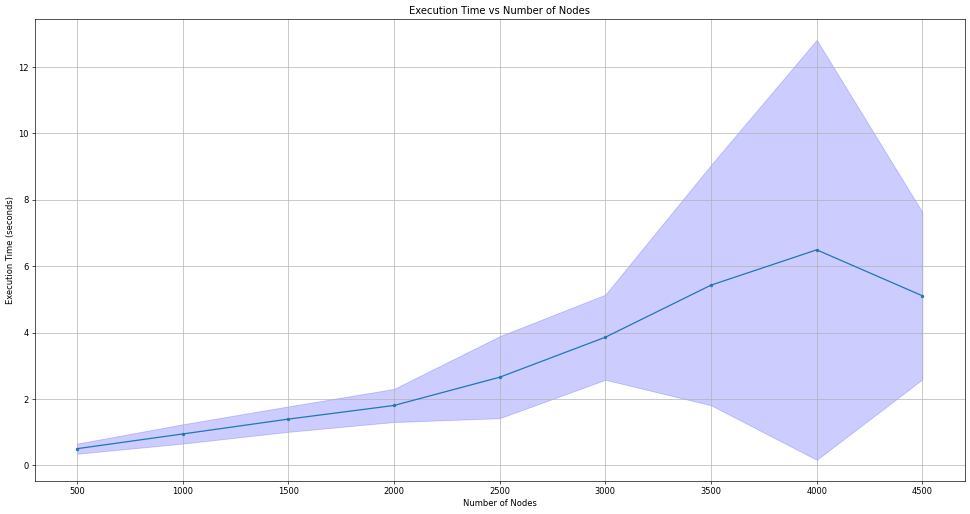

In [ ]:
exe_time = {'500': [0.4581120014190674, 0.45059800148010254, 0.5010545253753662, 0.46410465240478516, 0.42456984519958496, 0.48360109329223633, 0.40109753608703613, 0.5332319736480713, 0.5959591865539551, 0.5724363327026367, 0.5032958984375, 0.4311385154724121, 0.7208421230316162, 0.5032010078430176, 0.5340852737426758, 0.4380183219909668, 0.3953819274902344, 0.43403005599975586, 0.6236729621887207, 0.45298337936401367, 0.44782495498657227, 0.5842978954315186, 0.48772144317626953, 0.4962325096130371, 0.5586264133453369, 0.5851852893829346, 0.4396703243255615, 0.4649925231933594, 0.5301463603973389, 0.41685032844543457, 0.5575761795043945, 0.43943166732788086, 0.5608692169189453, 0.4329831600189209, 0.4831807613372803, 0.543717622756958, 0.3826265335083008, 0.5328400135040283, 0.6421306133270264, 0.5211575031280518, 0.46594977378845215, 0.43128323554992676, 0.44998645782470703, 0.38428330421447754, 0.6345345973968506, 0.5476698875427246, 0.4843618869781494, 0.3989856243133545, 0.5073516368865967, 0.5379698276519775, 0.5764141082763672, 0.630962610244751, 0.5544004440307617, 0.44918084144592285, 0.46866607666015625, 0.4035153388977051, 0.443772554397583, 0.5332651138305664, 0.5356388092041016, 0.7162344455718994, 0.5161283016204834, 0.4640038013458252, 0.6504931449890137, 0.49919772148132324, 0.45359277725219727, 0.5866138935089111, 0.4661111831665039, 0.43411779403686523, 0.46956539154052734, 0.56386399269104, 0.5189745426177979, 0.48348450660705566, 0.39984655380249023, 0.3800849914550781, 0.5717625617980957, 0.5674371719360352, 0.4830310344696045, 0.3982417583465576, 0.7671315670013428, 0.4852311611175537, 0.5138530731201172, 0.5645668506622314, 0.6402225494384766, 0.5718948841094971, 0.4356725215911865, 0.4513583183288574, 0.44533514976501465, 0.3993566036224365, 0.5133304595947266, 0.44586777687072754, 0.4644510746002197, 0.5339531898498535, 0.49294281005859375, 0.4671156406402588, 0.5313408374786377, 0.5703983306884766, 0.5019187927246094, 0.4984889030456543, 0.5335409641265869, 0.44677162170410156],
            '1000': [1.099334716796875, 1.0818760395050049, 1.2234783172607422, 1.0014231204986572, 1.018235445022583, 1.0012257099151611, 0.9189538955688477, 0.8666131496429443, 1.0865707397460938, 1.0002226829528809, 1.1113865375518799, 0.7644703388214111, 0.9642407894134521, 0.7878713607788086, 1.1504299640655518, 1.175316333770752, 0.9669392108917236, 1.169682502746582, 0.9626278877258301, 0.7530395984649658, 1.246178150177002, 1.1500415802001953, 0.9942636489868164, 0.9743754863739014, 0.8474583625793457, 1.1500520706176758, 1.133768081665039, 0.7500171661376953, 1.0160226821899414, 1.1810476779937744, 1.0801372528076172, 0.9337272644042969, 1.1032013893127441, 0.7668960094451904, 1.1970760822296143, 1.3163881301879883, 0.9073820114135742, 0.8841016292572021, 1.1027476787567139, 0.8492259979248047, 0.85345458984375, 1.0137171745300293, 1.0928232669830322, 0.7935409545898438, 0.993823766708374, 0.7632942199707031, 0.937272310256958, 1.0004234313964844, 0.9234395027160645, 1.0976617336273193, 1.113006353378296, 0.8652760982513428, 0.7172377109527588, 1.0312018394470215, 0.8862955570220947, 1.1336405277252197, 0.9207885265350342, 0.7307534217834473, 0.9012656211853027, 0.9680981636047363, 0.995507001876831, 0.8822269439697266, 0.6941542625427246, 0.9557571411132812, 0.7347941398620605, 0.6913819313049316, 0.8845663070678711, 0.7339420318603516, 0.9280273914337158, 0.949887752532959, 0.933363676071167, 0.663299560546875, 1.0550477504730225, 0.8829684257507324, 0.909369707107544, 0.7279424667358398, 0.8750338554382324, 0.9668533802032471, 1.100379467010498, 0.7549660205841064, 0.7031631469726562, 0.765394926071167, 1.0131397247314453, 0.8980872631072998, 1.1153128147125244, 0.9632015228271484, 0.9136714935302734, 0.946995735168457, 0.9665467739105225, 0.8419268131256104, 0.7250649929046631, 0.8668403625488281, 0.7413671016693115, 0.9284465312957764, 1.0658392906188965, 0.9997813701629639, 0.882615327835083, 0.9126143455505371, 0.7409617900848389, 0.9648737907409668],
            '1500': [1.7346501350402832, 1.238394021987915, 1.3662805557250977, 1.1016476154327393, 1.398555040359497, 1.5676021575927734, 1.3195087909698486, 1.1197116374969482, 1.430739164352417, 1.316901445388794, 1.3844208717346191, 1.45326566696167, 1.4306437969207764, 1.3828558921813965, 1.3411648273468018, 1.2320854663848877, 1.1363601684570312, 1.0833544731140137, 1.3044381141662598, 1.1658060550689697, 1.182492971420288, 1.4497365951538086, 1.6397981643676758, 1.4143569469451904, 1.165982961654663, 1.5146920680999756, 1.1138076782226562, 1.5476975440979004, 1.0665252208709717, 1.7598872184753418, 1.135122537612915, 1.3185334205627441, 1.4181082248687744, 1.4860749244689941, 1.1833221912384033, 1.4499366283416748, 1.1836726665496826, 1.3992981910705566, 1.4476099014282227, 1.517909288406372, 1.1698689460754395, 1.5519981384277344, 1.381896734237671, 1.2381529808044434, 1.5170283317565918, 1.4004085063934326, 1.4918267726898193, 1.199023723602295, 1.3506319522857666, 1.1857848167419434, 1.516352653503418, 1.615452527999878, 1.3359124660491943, 1.415316104888916, 1.5333454608917236, 1.062650203704834, 1.3973674774169922, 1.499587059020996, 1.570817232131958, 1.3611373901367188, 1.1000149250030518, 1.589815616607666, 1.262948989868164, 1.3504412174224854, 1.0664598941802979, 1.1985702514648438, 1.686272382736206, 1.530259132385254, 1.4042444229125977, 1.4700605869293213, 1.2985248565673828, 1.7205662727355957, 1.545295238494873, 1.4667549133300781, 1.4685416221618652, 1.6137104034423828, 1.5985090732574463, 1.0012543201446533, 1.5032868385314941, 1.4737424850463867, 1.5471320152282715, 1.8843286037445068, 1.1578290462493896, 1.5656852722167969, 1.6381402015686035, 1.6778178215026855, 1.5176565647125244, 1.4841747283935547, 1.361816167831421, 1.0825104713439941, 1.544283151626587, 1.4861857891082764, 1.2164549827575684, 1.204228401184082, 1.3334109783172607, 1.6149318218231201, 1.4341490268707275, 1.4993243217468262, 1.2304224967956543, 1.9359920024871826],
            '2000': [2.085989475250244, 2.2498397827148438, 1.5848240852355957, 1.6666820049285889, 1.8307199478149414, 1.4505105018615723, 1.4843180179595947, 2.2014896869659424, 1.8512928485870361, 1.4542279243469238, 1.3647112846374512, 1.637190818786621, 2.0794057846069336, 2.1989352703094482, 1.3690507411956787, 1.5905795097351074, 1.9836320877075195, 2.067720413208008, 2.0152862071990967, 1.531334400177002, 1.7184703350067139, 1.6188297271728516, 1.7867398262023926, 2.0162880420684814, 1.9702014923095703, 1.8950846195220947, 2.068190813064575, 1.6816058158874512, 1.819044589996338, 1.812692403793335, 1.465226173400879, 2.2005615234375, 1.6236462593078613, 1.9842572212219238, 2.0640461444854736, 1.9800095558166504, 1.4166996479034424, 2.17879319190979, 1.5804431438446045, 1.9523522853851318, 2.1198983192443848, 1.512040615081787, 2.046402931213379, 1.6520519256591797, 1.8536641597747803, 1.8967375755310059, 1.7793445587158203, 1.620560646057129, 1.8081927299499512, 1.6785874366760254, 2.308218479156494, 2.0463547706604004, 1.416442632675171, 2.101210117340088, 1.7996044158935547, 2.0145559310913086, 1.818068265914917, 1.3032233715057373, 1.2681519985198975, 2.058063268661499, 1.7440757751464844, 1.4312236309051514, 1.51694917678833, 1.9123871326446533, 1.3811798095703125, 1.9082441329956055, 1.7846579551696777, 2.132993221282959, 1.7894911766052246, 1.8210840225219727, 1.5167186260223389, 1.8833215236663818, 2.1163179874420166, 1.5835051536560059, 1.4831671714782715, 1.9841580390930176, 1.4689905643463135, 1.7330527305603027, 1.8519601821899414, 2.1044204235076904, 1.9792139530181885, 1.983449935913086, 1.7665274143218994, 1.9373831748962402, 1.9363927841186523, 1.4666204452514648, 1.7529420852661133, 2.0501480102539062, 1.9029054641723633, 1.4468767642974854, 1.854546070098877, 2.0333287715911865, 1.4718356132507324, 1.8648793697357178, 1.9319489002227783, 1.557680606842041, 1.9006812572479248, 1.7831599712371826, 2.015576124191284, 2.095457077026367],
            '2500': [2.4795868396759033, 2.430023193359375, 1.7841706275939941, 2.553795337677002, 2.4330878257751465, 2.399350881576538, 1.9654653072357178, 2.6219801902770996, 2.2700066566467285, 2.4638516902923584, 2.6693577766418457, 1.884626865386963, 2.4161489009857178, 2.5509512424468994, 2.2984516620635986, 2.3649604320526123, 2.502810001373291, 2.5492477416992188, 1.9314792156219482, 2.381485939025879, 2.4019219875335693, 2.3854734897613525, 2.4147098064422607, 2.6088943481445312, 2.1793994903564453, 2.3261516094207764, 2.3308069705963135, 2.063131332397461, 2.004246950149536, 2.271200180053711, 2.3644959926605225, 2.4494192600250244, 2.6334989070892334, 2.1169607639312744, 1.9218919277191162, 2.519806385040283, 2.435837507247925, 2.333198070526123, 2.249013900756836, 2.4693875312805176, 2.283222198486328, 2.8185770511627197, 2.3012242317199707, 1.8701398372650146, 1.6357860565185547, 2.71064829826355, 2.4487342834472656, 1.8152849674224854, 2.5845947265625, 2.2939372062683105, 2.4301841259002686, 2.3277008533477783, 2.7153475284576416, 2.736442804336548, 2.067361354827881, 2.515498638153076, 1.9682331085205078, 1.7491042613983154, 1.9003815650939941, 1.8276708126068115, 1.8359990119934082, 2.4739837646484375, 1.8784451484680176, 2.4817616939544678, 2.434422016143799, 2.737698793411255, 3.822841167449951, 3.3675248622894287, 3.648660182952881, 3.7680821418762207, 1.934122085571289, 2.484353542327881, 2.9799790382385254, 3.6778604984283447, 3.3159029483795166, 3.6770427227020264, 2.8726296424865723, 3.769775867462158, 2.5988636016845703, 3.8939707279205322, 3.9768571853637695, 3.595789909362793, 3.547921895980835, 3.9642722606658936, 3.586500644683838, 3.6778125762939453, 2.901392698287964, 4.364763975143433, 3.1477468013763428, 2.7187414169311523, 3.1799657344818115, 3.383920907974243, 3.0195364952087402, 3.7933669090270996, 2.9443235397338867, 3.079012393951416, 3.720085620880127, 2.7782881259918213, 3.4898934364318848, 2.6050453186035156],
            '3000': [4.777347564697266, 5.1677210330963135, 3.710326671600342, 4.189052581787109, 3.818702459335327, 4.459882974624634, 4.194751977920532, 2.7986087799072266, 4.240590810775757, 4.75471830368042, 3.796875, 4.18044114112854, 3.750026226043701, 3.4938933849334717, 3.9161224365234375, 3.165966749191284, 3.5249130725860596, 3.318225145339966, 4.538820266723633, 3.894223213195801, 4.8268349170684814, 3.688203811645508, 4.48462176322937, 4.140222787857056, 2.4913599491119385, 3.533235549926758, 4.340473890304565, 3.3729281425476074, 3.1501970291137695, 4.986968040466309, 3.1231279373168945, 3.7166590690612793, 4.19985294342041, 4.024493217468262, 3.0320703983306885, 4.682752370834351, 2.999843120574951, 3.366351842880249, 4.618460655212402, 2.7604455947875977, 4.34257173538208, 3.5322725772857666, 3.8912925720214844, 3.312595844268799, 4.766615390777588, 4.402108669281006, 2.9626121520996094, 4.275592565536499, 3.7275311946868896, 4.17558741569519, 3.0148215293884277, 4.749865770339966, 4.053763151168823, 5.016254186630249, 3.566873550415039, 3.5718395709991455, 2.1519877910614014, 3.018169641494751, 4.09973406791687, 4.362773418426514, 4.2164270877838135, 3.066437005996704, 4.483485460281372, 4.3997626304626465, 3.5966601371765137, 4.350203990936279, 3.3658504486083984, 4.133159160614014, 4.4330644607543945, 4.358455181121826, 3.5843393802642822, 3.550095796585083, 3.670238494873047, 3.2462503910064697, 3.4382991790771484, 3.548365592956543, 2.9503397941589355, 5.049897193908691, 2.9763383865356445, 5.103814363479614, 4.565515041351318, 4.428645849227905, 3.600081443786621, 3.639021158218384, 3.6301767826080322, 4.17652702331543, 3.7871437072753906, 3.1820781230926514, 3.9248242378234863, 4.293978929519653, 2.7527501583099365, 3.3489747047424316, 4.08536171913147, 3.679142475128174, 4.775246620178223, 4.075016736984253, 3.2030184268951416, 3.0951080322265625, 3.4682765007019043, 4.546694278717041],
            '3500': [5.085731267929077, 5.783748626708984, 4.834515571594238, 3.248030424118042, 3.404388427734375, 5.247689723968506, 3.164898157119751, 3.9654805660247803, 5.152206182479858, 4.617887020111084, 3.667076587677002, 4.600867986679077, 3.864886522293091, 4.177072286605835, 3.7483484745025635, 5.128769397735596, 3.9984028339385986, 4.968344449996948, 4.312545299530029, 5.2570483684539795, 3.7968132495880127, 5.4996538162231445, 3.2867515087127686, 3.6326024532318115, 5.015384674072266, 3.967949151992798, 3.2310738563537598, 3.285923957824707, 4.96599268913269, 4.932335138320923, 4.648486614227295, 4.028810977935791, 4.711595058441162, 4.225271701812744, 4.630838632583618, 6.395220041275024, 4.6680707931518555, 5.399111032485962, 5.254662275314331, 5.216331958770752, 5.465620279312134, 5.1501545906066895, 4.621590614318848, 4.31752347946167, 3.8846709728240967, 3.7829229831695557, 5.383344650268555, 3.879951000213623, 3.453049421310425, 4.197981595993042, 3.669811964035034, 4.948217153549194, 5.962608098983765, 5.495522975921631, 5.914535760879517, 5.8460307121276855, 4.715991973876953, 4.120324611663818, 4.248798847198486, 6.24472975730896, 4.633399248123169, 3.84975266456604, 3.6328790187835693, 4.690904140472412, 4.353204965591431, 5.852709531784058, 6.222411632537842, 6.05480170249939, 4.8287575244903564, 5.88958477973938, 4.0633320808410645, 6.482538461685181, 5.463294506072998, 3.802218437194824, 5.549901008605957, 6.169394254684448, 4.4299702644348145, 4.898998260498047, 6.555359363555908, 6.1327033042907715, 4.825717449188232, 13.210137367248535, 7.918473720550537, 8.74080228805542, 8.894325971603394, 7.638828754425049, 8.196966409683228, 6.2823240756988525, 9.34581732749939, 6.51786994934082, 9.096186637878418, 9.40989351272583, 8.09199571609497, 6.811369180679321, 10.247195959091187, 6.251826524734497, 8.00215220451355, 6.379989147186279, 9.549067258834839, 9.577564716339111],
            '4000': [7.46233057975769, 9.382318019866943, 14.217611074447632, 10.961409091949463, 11.879201173782349, 7.41352915763855, 8.499488353729248, 10.628274917602539, 10.779779434204102, 10.593522787094116, 8.408329963684082, 7.726787090301514, 9.932096004486084, 6.795126438140869, 9.637871742248535, 10.57006287574768, 10.383337259292603, 8.079736948013306, 9.17831039428711, 10.953955888748169, 9.611955881118774, 6.6866772174835205, 11.01188063621521, 8.986393690109253, 9.295322179794312, 8.236586332321167, 6.528492450714111, 7.6550233364105225, 11.746397256851196, 11.7590811252594, 9.023199319839478, 8.75732946395874, 9.630378723144531, 9.166943073272705, 10.097015619277954, 9.304033756256104, 10.191852807998657, 10.665738582611084, 10.851902961730957, 9.948365688323975, 8.617606163024902, 8.39261507987976, 10.968961477279663, 11.19172739982605, 11.207159280776978, 10.308314085006714, 7.57158350944519, 7.877732753753662, 2.865732192993164, 3.9656119346618652, 4.3535590171813965, 2.7189199924468994, 3.9854745864868164, 3.818781614303589, 3.9509520530700684, 3.1369996070861816, 3.8163931369781494, 3.7979257106781006, 2.8412857055664062, 2.825859546661377, 3.933709144592285, 3.5956833362579346, 4.019603729248047, 4.019678115844727, 3.5363035202026367, 4.132859468460083, 3.7367701530456543, 2.91388201713562, 3.0305023193359375, 3.0378711223602295, 4.318035364151001, 3.960541009902954, 3.668003797531128, 3.9323880672454834, 3.8351168632507324, 4.20142936706543, 3.7456746101379395, 3.1178700923919678, 3.2330803871154785, 4.032942056655884, 3.798799753189087, 3.9496726989746094, 3.585561752319336, 4.150067090988159, 2.9661366939544678, 4.014681577682495, 2.7320187091827393, 4.16840672492981, 3.217845916748047, 4.0000245571136475, 3.066359758377075, 3.313509941101074, 3.8907525539398193, 4.355463743209839, 3.993269205093384, 3.1136746406555176, 4.868621826171875, 3.968323230743408, 3.9322218894958496, 3.169149875640869],
            '4500': [4.235171794891357, 4.049260139465332, 4.401792764663696, 4.642007350921631, 4.3159308433532715, 3.900597333908081, 3.4003429412841797, 4.230039834976196, 4.694678783416748, 4.7160844802856445, 4.285968542098999, 3.1007888317108154, 6.381423473358154, 4.697406053543091, 4.9704060554504395, 7.116521120071411, 6.599103212356567, 4.7997307777404785, 6.033798456192017, 7.199112892150879, 7.051423072814941, 7.479005575180054, 6.777757167816162, 6.117790937423706, 7.181301832199097, 6.811962366104126, 7.23833966255188, 6.364338159561157, 4.400986671447754, 4.719555377960205, 6.5204808712005615, 6.385792970657349, 4.938338279724121, 6.851914882659912, 4.7369468212127686, 5.649520397186279, 6.687054872512817, 5.529618263244629, 5.729830741882324, 5.297925233840942, 5.186049461364746, 4.809414863586426, 6.928869724273682, 7.567267656326294, 4.483929872512817, 4.968040943145752, 4.4387288093566895, 6.041748285293579, 6.475100994110107, 6.900027275085449, 7.02076530456543, 4.365552186965942, 5.68485426902771, 4.347158670425415, 6.262521982192993, 5.4830920696258545, 6.418281555175781, 5.6021974086761475, 4.348028182983398, 5.890331745147705, 4.637075662612915, 6.0587944984436035, 5.361552953720093, 5.975141763687134, 6.532266616821289, 4.180381774902344, 6.582395315170288, 6.316256046295166, 6.9987876415252686, 5.126060485839844, 6.109293699264526, 5.128476858139038, 4.807127952575684, 5.260972499847412, 3.232733726501465, 2.9336419105529785, 4.654799222946167, 3.119503974914551, 4.02144193649292, 4.072233438491821, 4.045252561569214, 4.15210747718811, 3.2334067821502686, 3.311065435409546, 4.782343864440918, 4.464642286300659, 3.0531134605407715, 4.517455101013184, 3.246962785720825, 3.1198179721832275, 3.32742977142334, 4.261122226715088, 4.165461301803589, 3.322427988052368, 4.469501495361328, 4.022164344787598, 4.0983240604400635, 4.24168062210083, 2.963916301727295, 3.358532667160034],
            }

figure(figsize=(20, 10), dpi=60)
plt.plot(list(exe_time.keys()), [sum(exe_time[f"{N}"])/num_of_sim_runs for N in exe_time.keys()], marker='.')
plt.fill_between(list(exe_time.keys()), 
                 [np.mean(exe_time[f"{N}"]) - 2*np.std(exe_time[f"{N}"]) for N in exe_time.keys()],
                 [np.mean(exe_time[f"{N}"]) + 2*np.std(exe_time[f"{N}"]) for N in exe_time.keys()],
                 alpha=0.2, color='blue', label='Execution Time')
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Number of Nodes")
plt.grid()
plt.show()

We observe a decline in confidence as we increase the simulation length. These observations overlap with our earlier findings.